<a href="https://colab.research.google.com/github/LogicOber/ML4SCI/blob/main/%5BML4Sci%5D_UNet(Release_Version_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subtask 01 - Data Exploration

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def load_data(data_path):
    """
    Loads a dataset from a given file path.

    Args:
        data_path (str): The path to the data file, expected to be a NumPy `.npy` file containing a dictionary.

    Returns:
        dict: The loaded data as a dictionary.
    """
    data = np.load(data_path, allow_pickle=True)
    data = data.item()
    return data

# Load and verify data
data_path = "/content/data/train/data_02005.npy"
result = load_data(data_path)

# Print data structure
for key, item in result.items():
    print(key, item.shape)

field_node (2051, 3)
coord (2051, 2)
edge_index_bi (2, 11858)
cell_node_list (3878, 3)
mask_bd (2051, 1)
mask_wall (2051, 1)
mask_inlet (2051, 1)
mask_outlet (2051, 1)
mask_object (2051, 1)


## 1.Load data into memory

In [9]:
def load_data(data_path):
    """
    Loads a dataset from a given file path.

    Args:
        data_path (str): The path to the data file, expected to be a NumPy `.npy` file containing a dictionary.

    Returns:
        dict: The loaded data as a dictionary.
    """
    # Load the .npy file with allow_pickle=True since it contains a dictionary
    data = np.load(data_path, allow_pickle=True)

    # Convert the loaded numpy array to dictionary using .item()
    data = data.item()

    return data

In [10]:
# Set data directory path
data_dir = "/content/data"

# Build full file path
data_path = os.path.join(data_dir, "train/data_02005.npy")

# Load data
result = load_data(data_path)

# Print data structure
for key, item in result.items():
    print(key, item.shape)

field_node (2051, 3)
coord (2051, 2)
edge_index_bi (2, 11858)
cell_node_list (3878, 3)
mask_bd (2051, 1)
mask_wall (2051, 1)
mask_inlet (2051, 1)
mask_outlet (2051, 1)
mask_object (2051, 1)


## 2. Data visulisation

Complete the visulise_data function - the function should be able to plot the physical fields of the data.

A Demo output:
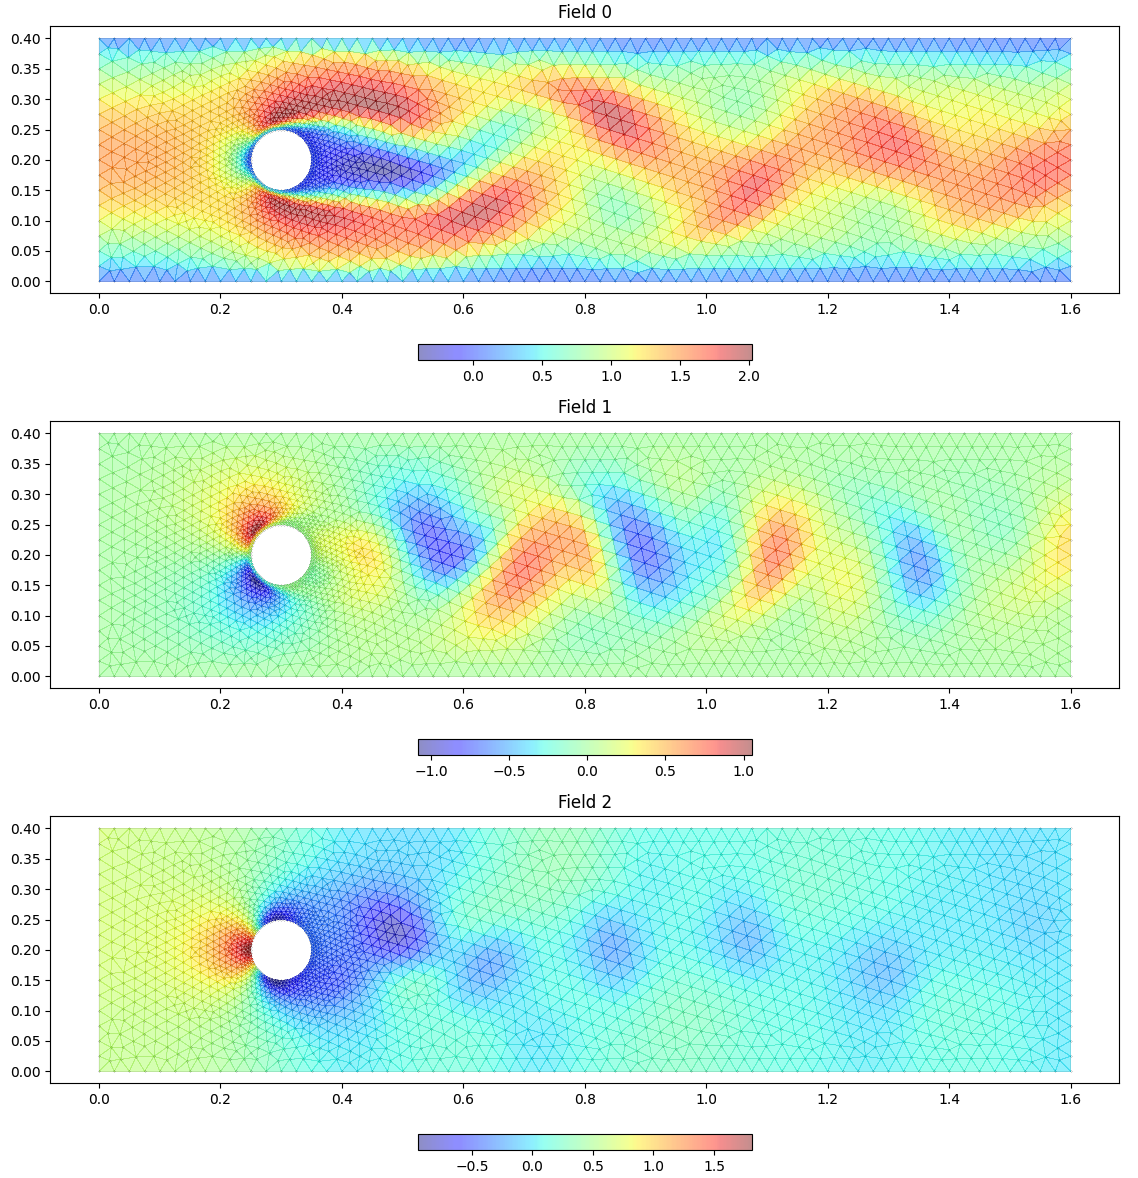

In [11]:
def visulise_data(data_path, cmap="jet"):
    """
    Visualizes three fields from the dataset in a 3-row subplot.

    Args:
        data_path (str): The path to the `.npy` file containing the dataset.
        cmap (str, optional): The colormap to use for visualization. Default is "jet".

    Returns:
        tuple: A tuple containing the figure (`fig`) and a list of axis (`axes`) objects.
    """
    # Load the data
    data = load_data(data_path)

    # Extract coordinates and field values
    coord = data['coord']
    field_node = data['field_node']

    # Create triangulation from cell_node_list
    triangles = data['cell_node_list']

    # Create figure with 3 subplots (one for each field component)
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))

    # Plot each field component
    field_names = ['u', 'v', 'p']  # velocity components (u,v) and pressure (p)
    for i in range(3):
        # Create triangulation
        triang = tri.Triangulation(coord[:, 0], coord[:, 1], triangles)

        # Plot the field
        im = ax[i].tricontourf(triang, field_node[:, i], cmap=cmap)
        ax[i].set_aspect('equal')
        ax[i].set_title(f'Field Component: {field_names[i]}')

        # Add colorbar
        plt.colorbar(im, ax=ax[i])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return fig, ax

(<Figure size 1000x1500 with 6 Axes>,
 array([<Axes: title={'center': 'Field Component: u'}>,
        <Axes: title={'center': 'Field Component: v'}>,
        <Axes: title={'center': 'Field Component: p'}>], dtype=object))

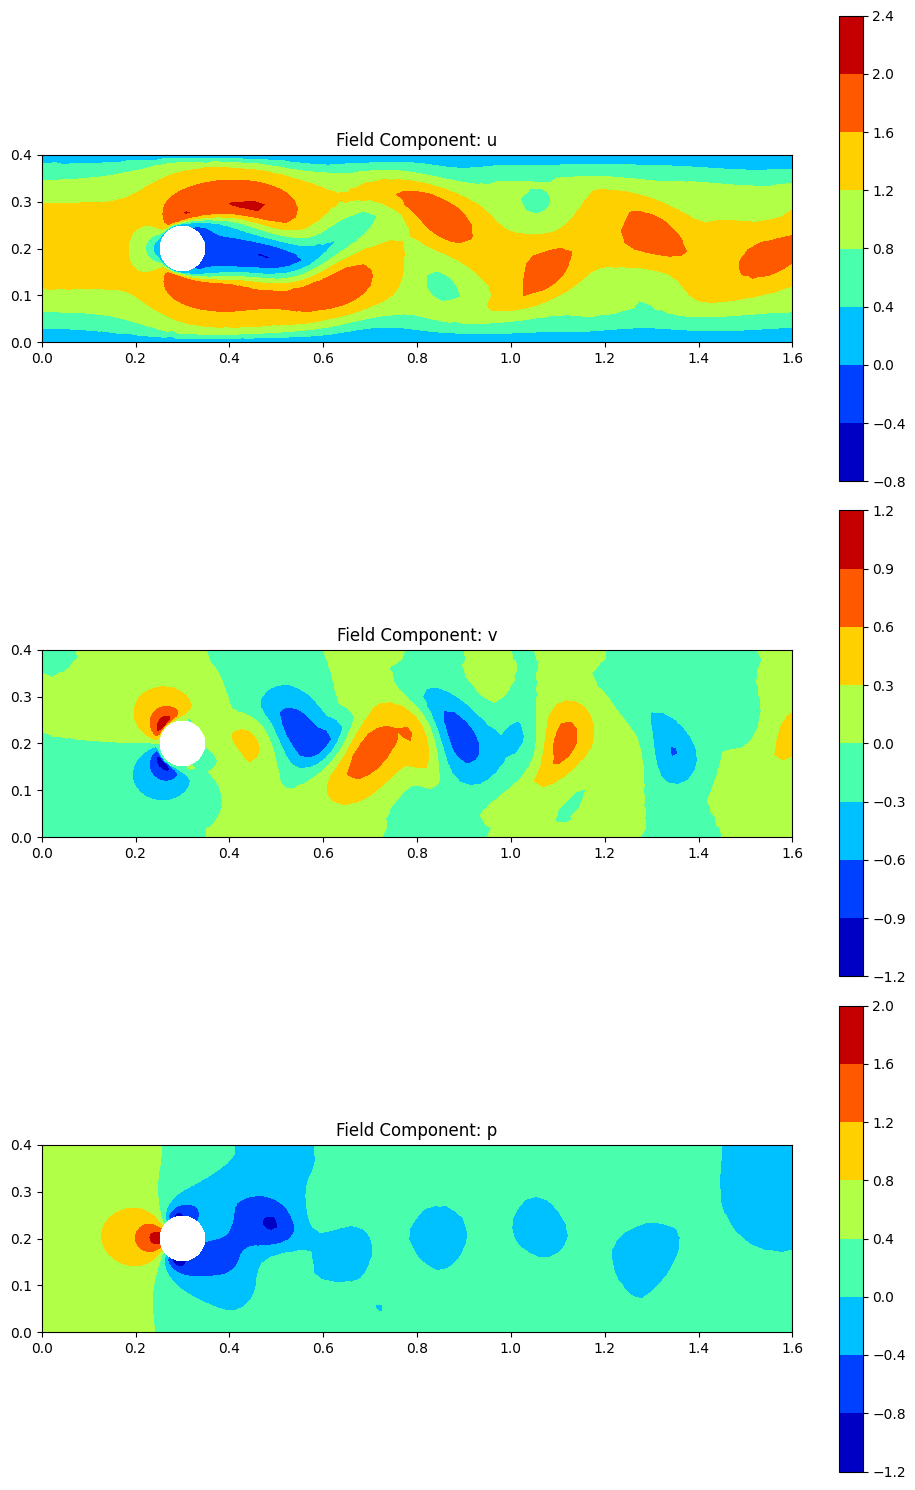

In [12]:
visulise_data(data_path)

## 3. Data Statistics

In [13]:
import glob
from natsort import natsorted

In [14]:
def get_mean_std(data_folder_path):
    """
    Computes the mean and standard deviation of the field node values across multiple dataset files.

    Args:
        data_folder_path (str): The path to the folder containing multiple `.npy` dataset files.

    Returns:
        tuple: A tuple containing:
            - `mean` (numpy.ndarray): The mean values computed across all datasets.
            - `std` (numpy.ndarray): The standard deviation values computed across all datasets.
    """
    # Get all .npy files in the folder
    file_list = natsorted(glob.glob(os.path.join(data_folder_path, "*.npy")))

    # Initialize list to store all field_node values
    all_fields = []

    # Load all files and collect field_node values
    for file_path in file_list:
        data = load_data(file_path)
        all_fields.append(data['field_node'])

    # Convert list to numpy array
    all_fields = np.array(all_fields)

    # Compute mean and standard deviation
    mean = np.mean(all_fields, axis=0)
    std = np.std(all_fields, axis=0)

    return mean, std

In [15]:
# Call the function with local path
get_mean_std("/content/data/train")

(array([[ 9.75305489e-01, -4.24084681e-02,  2.60631879e-04],
        [ 8.80742450e-01, -6.04991770e-02, -7.08541153e-13],
        [ 7.77275885e-01, -3.59553558e-02,  7.47730821e-03],
        ...,
        [ 8.85275078e-02,  6.31022454e-02,  1.76262126e+00],
        [-1.99735001e-09, -2.22222418e-08,  1.80476553e+00],
        [-1.00583762e-08, -1.36556919e-08,  1.78060081e+00]]),
 array([[1.80767330e-01, 1.95465412e-01, 4.86864510e-02],
        [1.93384819e-01, 1.54723801e-01, 5.52556829e-12],
        [1.71093644e-01, 1.15920574e-01, 3.68852185e-02],
        ...,
        [1.37858575e-03, 2.70660884e-02, 1.25039219e-02],
        [3.65371488e-07, 3.88171951e-05, 1.20363520e-02],
        [5.47947181e-06, 3.86692426e-05, 1.51686547e-02]]))

## 4.Data interpolation and masking

The grid_data should have shape:(3, 80, 320)

In [16]:
from scipy.interpolate import griddata

def get_grid_and_mask(data):
    """
    Generates a structured grid and a corresponding mask for the given dataset.

    Args:
        data (dict): A dictionary containing simulation data, with keys:
            - "coord": A NumPy array of shape (N, 2) representing the coordinates of nodes.
            - "field_node": A NumPy array of shape (N, D) containing field values for each node.

    Returns:
        tuple: A tuple containing:
            - `grid_data` (numpy.ndarray): The interpolated field data on a structured grid.
            - `mask_grid` (numpy.ndarray): A binary mask indicating regions within a circular mask.

    Task:
    - Define grid parameters:
        - `grid_num_x`, `grid_num_y`: The number of grid points in the x and y directions.
        - `x_min`, `x_max`, `y_min`, `y_max`: Determine the bounding box of the data.
    - Create a structured grid using `numpy.meshgrid` and flatten the coordinates.
    - Compute a circular mask based on distance from a predefined center (`x_center`, `y_center`) with radius `r`.
    - Interpolate the field values using `scipy.interpolate.griddata`:
        - Loop over each field dimension and interpolate onto the grid using cubic interpolation.
        - Apply the mask by setting masked grid values to zero.
    - Reshape the interpolated grid data into `(num_dim, grid_num_y, grid_num_x)`.
    - Reshape the mask into `(1, grid_num_y, grid_num_x)`.
    """
    # Define grid parameters
    grid_num_x = 320
    grid_num_y = 80

    # Get data bounds
    x_min, x_max = 0.0, 1.6  # Domain bounds from the physics problem
    y_min, y_max = 0.0, 0.4  # Domain bounds from the physics problem

    # Create structured grid
    x = np.linspace(x_min, x_max, grid_num_x)
    y = np.linspace(y_min, y_max, grid_num_y)
    X, Y = np.meshgrid(x, y)

    # Flatten grid coordinates for interpolation
    grid_points = np.column_stack((X.flatten(), Y.flatten()))

    # Define circular mask parameters
    x_center, y_center = 0.2, 0.2  # Center of the circular object
    r = 0.05  # Radius of the circular object

    # Compute circular mask
    dist = np.sqrt((X - x_center)**2 + (Y - y_center)**2)
    mask = (dist > r).astype(float)
    mask_grid = mask.reshape(1, grid_num_y, grid_num_x)

    # Initialize grid data array
    num_dim = data['field_node'].shape[1]  # Number of field dimensions (u, v, p)
    grid_data = np.zeros((num_dim, grid_num_y, grid_num_x))

    # Interpolate each field component
    for i in range(num_dim):
        field_values = data['field_node'][:, i]
        grid_values = griddata(data['coord'], field_values, grid_points, method='cubic')
        grid_values = grid_values.reshape(grid_num_y, grid_num_x)

        # Apply mask
        grid_values = grid_values * mask
        grid_data[i] = grid_values

    return grid_data, mask_grid

Then we will use the `get_grid_and_mask` function to pre-process the dataset - we read the original data in the first place, process it and save the processed data in-place.

In [17]:
from tqdm import tqdm

def post_process(dataset_dir="/content/data/train/"):
    file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
    file_names = natsorted(file_names)

    for file_name in tqdm(file_names, desc="Processing files"):
        data = load_data(file_name)
        grid_data, mask = get_grid_and_mask(data)
        data["field_conv"] = grid_data
        data["mask"] = mask
        np.save(file_name, data)

In [18]:
# Process training data
post_process(dataset_dir="/content/data/train")

Processing files: 100%|██████████| 3000/3000 [07:42<00:00,  6.48it/s]


In [19]:
# Process test data
post_process(dataset_dir="/content/data/test")

Processing files: 100%|██████████| 500/500 [01:17<00:00,  6.45it/s]


In [20]:
# Process validation data
post_process(dataset_dir="/content/data/val")

Processing files: 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


(3, 80, 320)


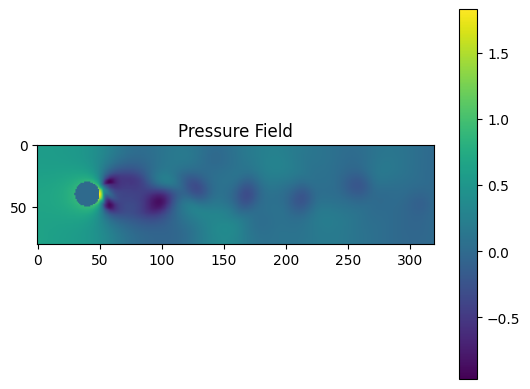

In [21]:
# Load and visualize processed data
data = load_data(data_path)
grid_data = data["field_conv"]
print(grid_data.shape)
plt.imshow(grid_data[2])
plt.colorbar()  # Add colorbar to show the value scale
plt.title('Pressure Field')  # Add title to indicate this is the pressure field
plt.show()

(1, 80, 320)


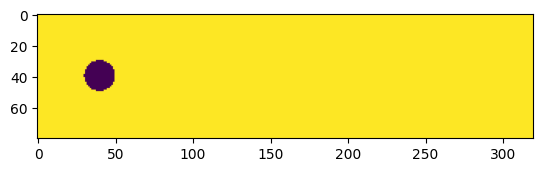

In [22]:
mask_data = data["mask"]
print(mask_data.shape)
plt.imshow(mask_data[0])
plt.show()

# Subtask 02 - Dataset construction and Data Loading

In [23]:
import torch
from torch.utils.data import DataLoader, Dataset
from natsort import natsorted
from scipy.interpolate import griddata

Please bear in mind this is time-sequence-like dataset: each entry of the dataset should contain a input (previous time step) and a ouput (later time step)

In [80]:
class CNNDataset(Dataset):
    """
    A custom PyTorch dataset class for loading sequential data samples from `.npy` files.

    Args:
        dataset_dir (str, optional): Path to the directory containing `.npy` dataset files.
        transform (callable, optional): A function to apply transformations to input data.
        target_transform (callable, optional): A function to apply transformations to target data.

    Attributes:
        file_names (list): A sorted list of file paths to dataset files.
        transform (callable): Transformation function for input data.
        target_transform (callable): Transformation function for target data.
    """

    def __init__(self, dataset_dir=None, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

        self.file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
        self.file_names = natsorted(self.file_names)

    def __len__(self):
        # YOUR CODE HERE
        return len(self.file_names) - 1  # -1 because we need pairs of consecutive samples

    def load_data(self, data_path):
        # YOUR CODE HERE
        data = np.load(data_path, allow_pickle=True)
        return data.item()

    def __getitem__(self, idx):
        # YOUR CODE HERE
        # Get input and output indices
        in_idx = idx
        out_idx = idx + 1

        # Load input and output data
        in_data = self.load_data(self.file_names[in_idx])
        out_data = self.load_data(self.file_names[out_idx])

        # Get the field data (already processed to grid format)
        in_field = in_data['field_conv']
        out_field = out_data['field_conv']

        # Convert to numpy arrays first
        in_field = np.array(in_field)
        out_field = np.array(out_field)

        # Apply transforms if specified
        if self.transform:
            in_field = self.transform(in_field)
        if self.target_transform:
            out_field = self.target_transform(out_field)

        # Return as dictionaries with explicit float32 type
        return {"field_conv": torch.from_numpy(in_field).float()}, {"field_conv": torch.from_numpy(out_field).float()}

In [81]:
# Set the local data directory path
dataset_dir = "/content/data/test"

# Create dataset instance
dataset = CNNDataset(dataset_dir)
print(len(dataset))

# Get a sample pair at index 248
idx = 248
sample, target = dataset[idx]

499


## 2. Data Transformation

In [82]:
class Normalise:
    """
    A transformation class to normalize dataset values using precomputed mean and standard deviation.

    Args:
        mean (numpy.ndarray): The mean values for normalization.
        std (numpy.ndarray): The standard deviation values for normalization.

    Attributes:
        mean (numpy.ndarray): Stored mean values.
        std (numpy.ndarray): Stored standard deviation values.

    Task:
    - Implement the `__init__` method:
        - Store the `mean` and `std` values as instance attributes.
    - Implement the `__call__` method:
        - Normalize the `"field_node"` values in `data` using std and mean calculated before
        - Return the updated `data` dictionary.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        # Convert mean and std to same device as data if needed
        if torch.is_tensor(data):
            mean = torch.tensor(self.mean, device=data.device)
            std = torch.tensor(self.std, device=data.device)
            # Reshape mean and std to match data dimensions
            mean = mean.view(-1, 1, 1)  # Shape becomes (3, 1, 1)
            std = std.view(-1, 1, 1)    # Shape becomes (3, 1, 1)
            return (data - mean) / std
        else:
            mean = self.mean.reshape(-1, 1, 1)  # Shape becomes (3, 1, 1)
            std = self.std.reshape(-1, 1, 1)    # Shape becomes (3, 1, 1)
            return (data - mean) / std


class ToFloatTransform:
    def __init__(self, scale=True):
        return

    def __call__(self, data):
        data["field_conv"] = torch.from_numpy(data["field_conv"]).float()
        return data


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for transform in self.transforms:
            data = transform(data)
        return data

In [83]:
# Calculate mean and std from training data
train_dir = "/content/data/train/"
mean, std = get_mean_std(train_dir)

# Reshape mean and std to correct shape for u, v, p components
mean = mean.mean(axis=0)  # Average across all nodes
std = std.mean(axis=0)    # Average across all nodes

# Create transform pipeline
transform = Compose([
    Normalise(mean=mean, std=std)
])

# Create dataset with transforms
dataset_dir = "/content/data/test/"
dataset = CNNDataset(dataset_dir=dataset_dir, transform=transform, target_transform=transform)

# Get first sample and target
idx = 0
data_in, target = dataset[idx]
conv_in = data_in

## 3. Data Loader


In [84]:
Loader = DataLoader(dataset=dataset, num_workers=12, batch_size=16)

# Subtask 03 - UNet

## 1.UNet

This implementation of U-Net is provided as a demonstrative demo to give you a starting point for understanding how encoder-decoder architectures work. Feel free to alter the architecture, adjust hyperparameters, experiment with different activation functions, or modify the number of layers to suit your needs. The goal is to encourage exploration and hands-on learning, so don't hesitate to play around with it and make improvements! 🚀

You might find this helpful when calculating output size:

$$Size_{out} = \lfloor\frac{Size_{in} + 2Padding - Kernel}{Stride}\rfloor + 1$$

In [85]:
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

class UNet(nn.Module):
    def __init__(self, c_in=3, c_hidden=64, c_out=3, dropout=0, depth=4):
        super(UNet, self).__init__()

        # Input layer: convert input channels to hidden channels
        self.input_layer = nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)

        # Encoder: double channels and halve spatial dimensions at each step
        self.encoder = nn.ModuleList()
        for i in range(depth):
            in_c = c_hidden * (2**i)
            out_c = c_hidden * (2**(i+1))
            self.encoder.append(
                self.conv(in_c, out_c, out_c, k=3, s=2, p=1, dropout=dropout)
            )

        # Bottleneck: process the most compressed representation
        bottleneck_c = c_hidden * (2**depth)
        self.bottleneck = self.conv(bottleneck_c, bottleneck_c, bottleneck_c,
                                  k=3, s=1, p=1, dropout=dropout)

        # Decoder: halve channels and double spatial dimensions at each step
        self.decoder = nn.ModuleList()
        for i in range(depth):
            in_c = c_hidden * (2**(depth-i))
            out_c = c_hidden * (2**(depth-i-1))
            self.decoder.append(nn.Sequential(
                self.deconv(in_c, out_c),
                self.conv(out_c * 2, out_c, out_c, k=3, s=1, p=1, dropout=dropout)
            ))

        # Output layer: map to desired output channels
        self.output_layer = nn.Conv2d(c_hidden, c_out, kernel_size=1)

    def conv(self, in_c, mid_c, out_c, k, s, p, dropout=0):
        # Double convolution block with batch norm and activation
        return nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size=k, stride=s, padding=p),
            nn.BatchNorm2d(mid_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(mid_c, out_c, kernel_size=k, stride=1, padding=p),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout)
        )

    def deconv(self, in_c, out_c):
        # Transposed convolution for upsampling
        return nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Initial convolution
        x = self.input_layer(x)

        # Store skip connections
        skips = []

        # Encoder path
        for enc in self.encoder:
            skips.append(x)
            x = enc(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path with skip connections
        for dec, skip in zip(self.decoder, reversed(skips)):
            # Upsample
            x = dec[0](x)
            # Concatenate with skip connection
            x = torch.cat([x, skip], dim=1)
            # Process combined features
            x = dec[1](x)

        # Final output
        x = self.output_layer(x)
        return x

In [86]:
model = UNet()
dummy = torch.randn((1, 3, 320, 80))
output = model(dummy)
print(output.shape)

torch.Size([1, 3, 320, 80])


In [87]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    avg_loss = 0.0
    for batch in loader:
        in_data, out_data = batch
        in_data, out_data = in_data["field_conv"].to(device), out_data["field_conv"].to(device)
        optimizer.zero_grad()
        pred = model(in_data)
        loss = criterion(pred, out_data)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss /= len(loader)
    return loss, model


def test_one_epoch(model, loader, criterion):
    model.eval()
    avg_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            in_data, out_data = batch
            in_data, out_data = in_data["field_conv"].to(device), out_data["field_conv"].to(device)
            pred = model(in_data)
            loss = criterion(pred, out_data)
            avg_loss += loss.item()
    avg_loss /= len(loader)
    return loss




def train(epoch, model, optimizer, loader_train, loader_test):
    criterion = torch.nn.MSELoss()
    model = model.to(device)
    for i in range(epoch):
        loss, model = train_one_epoch(
            model=model, loader=loader_train, optimizer=optimizer, criterion=criterion)
        print(f"Epoch \t{i+1}, Train Loss \t{loss}")
        if (i+1) % 50 == 0:
            info = test_one_epoch(
                model=model, loader=loader_test, criterion=criterion)
            print(f"\t Epoch \t{i+1}, Test Loss \t{loss}")
            model_path = os.path.join(
                os.path.abspath("."),
                f"epoch_{i+1}.pth"
            )
            torch.save(model.state_dict(), model_path)
            print(model_path, "saved")


In [88]:
# Feel free to experiment with these parameters to see how they affect training!
epoch = 100
lr = 1e-3
bs = 16

model = UNet()

train_set = CNNDataset(
    dataset_dir="/content/data/train/",
    transform=transform,
    target_transform=transform
)
test_set = CNNDataset(
    dataset_dir="/content/data/test/",
    transform=transform,
    target_transform=transform
)

loader_train = DataLoader(train_set, batch_size=bs, num_workers=0)
loader_test = DataLoader(test_set, batch_size=bs, num_workers=0)

# Init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [89]:
train(epoch=epoch, model=model, optimizer=optimizer, loader_train=loader_train, loader_test=loader_test)

Epoch 	1, Train Loss 	0.023430777713656425
Epoch 	2, Train Loss 	0.00585506297647953
Epoch 	3, Train Loss 	0.003929944708943367
Epoch 	4, Train Loss 	0.006134448107331991
Epoch 	5, Train Loss 	0.0021287729032337666
Epoch 	6, Train Loss 	0.005246378481388092
Epoch 	7, Train Loss 	0.0039606825448572636
Epoch 	8, Train Loss 	0.0027773731853812933
Epoch 	9, Train Loss 	0.004287288058549166
Epoch 	10, Train Loss 	0.0033688582479953766
Epoch 	11, Train Loss 	0.003481499617919326
Epoch 	12, Train Loss 	0.003860553028061986
Epoch 	13, Train Loss 	0.0024765031412243843
Epoch 	14, Train Loss 	0.004459110088646412
Epoch 	15, Train Loss 	0.006541876122355461
Epoch 	16, Train Loss 	0.0029306411743164062
Epoch 	17, Train Loss 	0.002792137209326029
Epoch 	18, Train Loss 	0.002381230005994439
Epoch 	19, Train Loss 	0.0022001571487635374
Epoch 	20, Train Loss 	0.004860955290496349
Epoch 	21, Train Loss 	0.0014644820475950837
Epoch 	22, Train Loss 	0.0017548301257193089
Epoch 	23, Train Loss 	0.00245976

In [90]:
def load_model(model, weight_path, strict=False):
    """
    Loads pre-trained weights into a PyTorch model from a given file path.

    Args:
        model (torch.nn.Module): The PyTorch model.
        weight_path (str): File path to the pre-trained model weights.

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    try:
        model.load_state_dict(torch.load(weight_path), strict=strict)
    except RuntimeError:
        state_dict = torch.load(weight_path, map_location=device)
        model.load_state_dict(state_dict, strict=strict)
    return model


def denormalise(data, mean, std):
    mean = mean[(...,) + (None,) * (data.ndim - mean.ndim)]
    std = std[(...,) + (None,) * (data.ndim - std.ndim)]
    return data * std + mean


def calc_norm_error(pred, truth, ord=2):
    """
    Compute the relative error of two input. input are supposed to have
    shape of (channel, height, width). Other shape might work but please
    be careful and aware of what you are doing.

    pred: The prediction output by model.
    truth: The ground truth against which error are measured.
    ord: the order of norm.
    """
    pred, truth = [vec.flatten() for vec in [pred, truth]]
    nume = torch.linalg.norm((pred - truth), ord=ord)
    deno = torch.linalg.norm(truth, ord=ord)
    return nume / deno

def calculate_error_and_inference(dataloader, model, mean, std):
    model.to(device)
    model.eval()
    error = 0.0
    pred_list = []
    ground_list = []
    with torch.no_grad():
        for batch in dataloader:
            data_in, target = batch
            data_in, target = data_in["field_conv"], target["field_conv"]
            data_in, target = data_in.to(device), target.to(device)
            pred = model(data_in)
            pred, target = denormalise(pred, mean, std), denormalise(target, mean, std)
            pred_list.append(pred.detach().cpu().numpy())
            ground_list.append(target.detach().cpu().numpy())
            error_i = calc_norm_error(pred, target)
            error += error_i.detach()
    error /= (len(dataloader) * dataloader.batch_size)
    return error, pred_list, ground_list


In [91]:
model = UNet(c_hidden=64)
model = load_model(model, "./epoch_100.pth")

# Update test dataset path
dataset_test = CNNDataset(
    dataset_dir="/content/data/test/",
    transform=transform,
    target_transform=transform
)
test_loader = DataLoader(dataset_test, batch_size=1, num_workers=4)

# Calculate mean and std from training data
train_dir = "/content/data/train/"
mean, std = get_mean_std(train_dir)
mean = mean.mean(axis=0)  # Average across all nodes
std = std.mean(axis=0)    # Average across all nodes

error, pred, ground = calculate_error_and_inference(
    test_loader,
    model,
    mean=torch.tensor(mean).to(device),
    std=torch.tensor(std).to(device)
)
print(error)

<ipython-input-90-786e158440f0>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path), strict=strict)


tensor(0.0030, device='cuda:0', dtype=torch.float64)


In [92]:
def interpolate_back(coord, data, method="cubic"):
    num_dim = data.shape[0]

    grid_num_x = 320
    grid_num_y = 80

    x_min, x_max = min(coord[:, 0]), max(coord[:, 0])
    y_min, y_max = min(coord[:, 1]), max(coord[:, 1])

    x_coord, y_coord = np.meshgrid(
        np.linspace(x_min, x_max, grid_num_x),
        np.linspace(y_min, y_max, grid_num_y)
    )
    coord_grid = np.column_stack((x_coord.flatten(), y_coord.flatten()))

    mesh_data = []
    for i in range(num_dim):
        mesh_data_i = griddata(coord_grid, data[i].flatten(), coord, method=method)
        mesh_data.append(mesh_data_i)
    mesh_data = np.stack(mesh_data, axis=1)

    return mesh_data

def pred_to_df(data):
    reshaped = data.reshape(-1, 3)
    df = pd.DataFrame(reshaped, columns=['Feature_1', 'Feature_2', 'Feature_3'])
    df.index.name = "ROW_ID"
    return df

In [93]:
# inference on the validation dataset:
dataset_val = CNNDataset(
    dataset_dir = "/content/data/val/",
    transform=transform, target_transform=transform)
val_loader = DataLoader(dataset_val, batch_size=1, num_workers=8)

coord = dataset_val[0][0]["coord"]
face = dataset_val[0][0]["cell_node_list"]

# Prediction
_, pred, ground = calculate_error_and_inference(
    val_loader, model,
    # YOUR CODE HERE - replace [0, 0, 0] with the mean/std you calculated
    mean = torch.tensor([[0, 0, 0]]).to(device),
    std = torch.tensor([[0, 0, 0]]).to(device),
)

# Interpolate back
for i in range(len(pred)):
    print(pred[i].shape)
    pred[i] = interpolate_back(coord, pred[i].squeeze(0))
    ground[i] = interpolate_back(coord, ground[i].squeeze(0))

KeyError: 'coord'

In [ ]:
pred = np.stack(pred, axis=0)
print(pred.shape)

The cell below will make a CSV file under the /content folder - download and submit it to the competition!

In [ ]:
import pandas as pd
print(pred.shape)
# save file for submission 1
pred_1 = np.stack(pred, axis=0)
np.save("pred_1.npy", pred_1)
pred_to_df(pred_1).to_csv("pred_1.csv", index=True)

Visualise one output sample to check if everything looks good

In [ ]:
import matplotlib.tri as tri
cmap = "jet"

left, right = min(coord[:, 0]), max(coord[:, 0])
bottom, top = min(coord[:, 1]), max(coord[:, 1])
value = pred[0, :, 0]

width = zeta * (right - left)
height = zeta * (top - bottom)

triangle = tri.Triangulation(coord[:, 0], coord[:, 1], face)

fig, ax = plt.subplots(figsize=(width, height))

ax.set_aspect("equal")
ax.triplot(triangle, 'ko-', ms=0.1, lw=0.1)
ax.tripcolor(triangle, value, cmap=cmap, alpha=0.4)

# 🔥 Additional Tasks: Experiment and Explore!

- 1️⃣ Investigate Interpolation Methods
  - The griddata function supports different interpolation techniques like "cubic", "linear", and "nearest". Experiment with these and analyze how they impact the quality of the interpolated field.

  - Does "cubic" provide smoother results than "linear"?
  - How does "nearest" compare in terms of accuracy and computation time?
  - Visualize the outputs for different interpolation methods and compare them.


- 2️⃣ Modify and Optimize the U-Net Architecture: The U-Net model provided is a basic version—feel free to tweak it! Try the following:

  - Increase or decrease the depth of the encoder/decoder.
  - Change the number of filters per layer.
  - Experiment with different activation functions like ReLU, LeakyReLU, or GELU.
  - Try batch normalization, dropout, or other regularization techniques to see their effect on performance.
- 3️⃣ Hyperparameter Tuning
  - Test different learning rates (lr), batch sizes (bs), and number of epochs to find the best combination for faster and more stable training. You can even implement learning rate scheduling to improve convergence!

- 4️⃣ Analyze Performance
Once you've tried different interpolation methods and U-Net architectures, compare their performance:

  - How does the choice of interpolation method impact model accuracy?
  - Does a deeper U-Net always perform better, or does it overfit?
  - What trade-offs exist between computational cost and output quality?

💡 Keep experimenting and take notes on your findings. Understanding these trade-offs will help you develop better models in real-world applications! 🚀